In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from datetime import timedelta

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [2]:
takehome_user_engagement = pd.read_csv('takehome_user_engagement.csv')
print(takehome_user_engagement.info())
takehome_user_engagement.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB
None


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


# Cleansing Data

In [3]:
takehome_user_engagement['time_stamp'] = pd.to_datetime(takehome_user_engagement['time_stamp']) # convert to datetime
takehome_user_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [4]:
takehome_user_engagement.visited.value_counts()

1    207917
Name: visited, dtype: int64

In [5]:
df = takehome_user_engagement.sort_values('time_stamp').reset_index(drop=True)
df['time_stamp'] = pd.to_datetime([df['time_stamp'].iloc[i].strftime("%Y/%m/%d") for i in range(len(df))])
df.head()

,time_stamp,user_id,visited
0,2012-05-31,10012,1
1,2012-05-31,3428,1
2,2012-05-31,9899,1
3,2012-05-31,1693,1
4,2012-06-01,6102,1


In [6]:
# number of days between first and last
df.time_stamp.max() - df.time_stamp.min()

Timedelta('736 days 00:00:00')

In [7]:
%time
# define adopted_user

from datetime import timedelta

initial_adopted_users = []

for i in range(1, 736):
    
    # create dataframe between 2 dates iteratively
    interval_df = df[(df['time_stamp'] <= df.time_stamp.min() + timedelta(i)) & 
                     (df['time_stamp'] > df.time_stamp.min() + timedelta(i-7))]
    
    # get only logins in separate days
    
    users_day = []
    for j in set(interval_df.time_stamp):
        users_day.append(interval_df[interval_df['time_stamp'] == j].user_id.unique()) 
    
    one_list = []
    for sublist in users_day:
        for i in sublist:
            one_list.append(i)
            
    ###
    
    # check the users that logged into the product on three separate days in this period
    interval_df = pd.Series(one_list).value_counts() == 3
    
    # append to the list of adopted users
    initial_adopted_users.append(interval_df.index[:interval_df.sum()].tolist())
    

# from the resulting list, create unique list with adopted users 
flat_list = []
for sublist in initial_adopted_users:
    for i in sublist:
        flat_list.append(i)

# adopted users
adopted_users = set(flat_list)

Wall time: 0 ns


In [8]:
# number of adopted users & percentage
print("The number of adopted users is {}.".format(len(adopted_users)))
print("The percentage of adopted users is {}%.".format(round(len(adopted_users)/len(df['user_id'].unique())*100, 1)))

The number of adopted users is 782.
The percentage of adopted users is 8.9%.


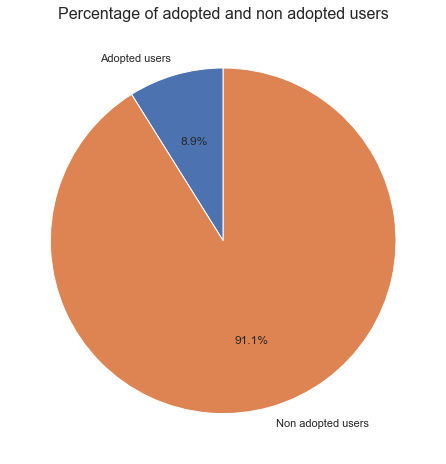

In [9]:
# define sizes
size_adopted = round(len(adopted_users)/len(df['user_id'].unique()), 3)
size_nonadopted = 1 - size_adopted

# formatting
labels = ["Adopted users", "Non adopted users"]
sizes = [size_adopted, size_nonadopted]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Percentage of adopted and non adopted users", fontsize=16)
plt.ylabel("")

plt.subplots_adjust(left=0, bottom=-0.5, right=1, top=1, wspace=0, hspace=0)
plt.show();

In [10]:
# takehome_users dataframe
takehome_users = pd.read_csv('takehome_users.csv', encoding='latin-1')

print(takehome_users.shape, "\n")
print(takehome_users.info())

takehome_users.head()

(12000, 10) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB
None


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [11]:
takehome_users['creation_time'] = pd.to_datetime(takehome_users['creation_time']) # convert to datetime
takehome_users.invited_by_user_id.fillna(0, inplace=True)  # replace NaN with 0
takehome_users.last_session_creation_time.fillna(0, inplace=True)  # replace NaN with 0
takehome_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  12000 non-null  float64       
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          12000 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 937.6+ KB


In [12]:
# add adopted user column (is_adopted)
is_adopted = []

for i in takehome_users['object_id']:
    if i in adopted_users:
        is_adopted.append(1)
    else:
        is_adopted.append(0)
        
takehome_users['is_adopted'] = is_adopted
takehome_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,is_adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [13]:
# check
takehome_users.is_adopted.value_counts()

0    11218
1      782
Name: is_adopted, dtype: int64

# EDA

C:\Users\danie\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


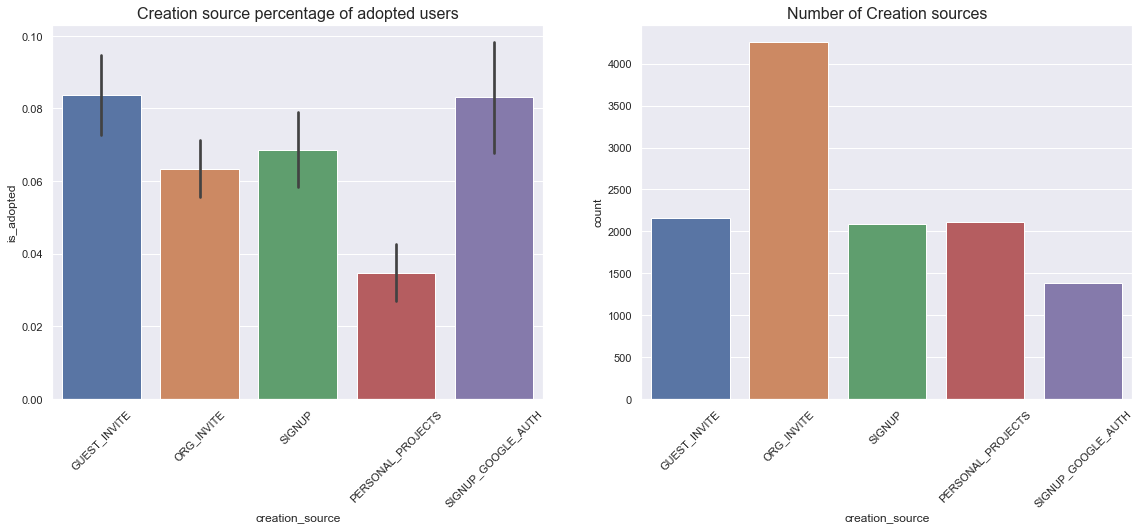

In [14]:
# Creation source percentage of adopted users
plt.subplot(1, 2, 1)
sns.barplot(x="creation_source", y="is_adopted", data=takehome_users)
plt.title('Creation source percentage of adopted users', fontsize=16)
plt.xticks(rotation=45)

# countplot creation sources
plt.subplot(1, 2, 2)
sns.countplot(takehome_users.creation_source)
plt.title('Number of Creation sources', fontsize=16)
plt.xticks(rotation=45)

plt.subplots_adjust(left=0, bottom=-0.3, right=2.5, top=1, wspace=0.2, hspace=0)
plt.show();

In [15]:
# absolute values
takehome_users[takehome_users['is_adopted'] == 1].creation_source.value_counts()

ORG_INVITE            270
GUEST_INVITE          181
SIGNUP                143
SIGNUP_GOOGLE_AUTH    115
PERSONAL_PROJECTS      73
Name: creation_source, dtype: int64

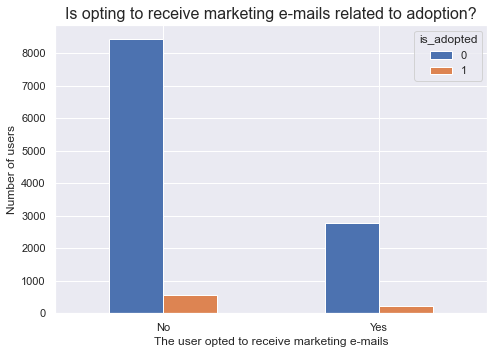

In [16]:
# crosstab plot
pd.crosstab(takehome_users['opted_in_to_mailing_list'], takehome_users['is_adopted']).plot(kind='bar')
plt.title('Is opting to receive marketing e-mails related to adoption?', fontsize=16)
plt.xlabel('The user opted to receive marketing e-mails')
plt.xticks([0, 1], ["No", "Yes"], rotation=0)
plt.ylabel("Number of users")

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0)
plt.show();

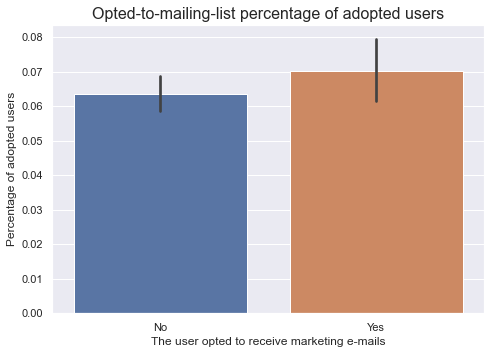

In [17]:
# percentage of adopted users
sns.barplot(x="opted_in_to_mailing_list", y="is_adopted", data=takehome_users)
plt.title('Opted-to-mailing-list percentage of adopted users', fontsize=16)
plt.xlabel('The user opted to receive marketing e-mails')
plt.xticks([0, 1], ["No", "Yes"], rotation=0)
plt.ylabel("Percentage of adopted users")

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0)
plt.show()

There is a slightly higher tendency to become an adopted user if he/she decided to receive marketing e-mails. Should we have expected a higher margin for adoption given that the user demonstrated his/her interest?

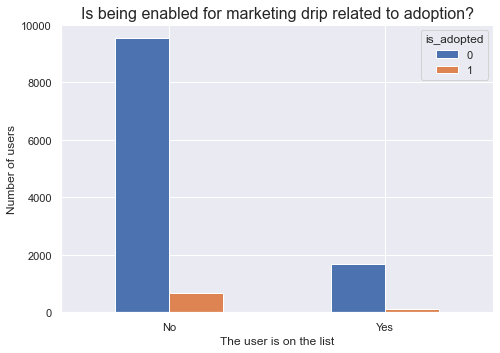

In [18]:
pd.crosstab(takehome_users['enabled_for_marketing_drip'], takehome_users['is_adopted']).plot(kind='bar')
plt.title('Is being enabled for marketing drip related to adoption?', fontsize=16)
plt.xlabel('The user is on the list')
plt.xticks([0, 1], ["No", "Yes"], rotation=0)
plt.ylabel("Number of users")

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0)
plt.show();

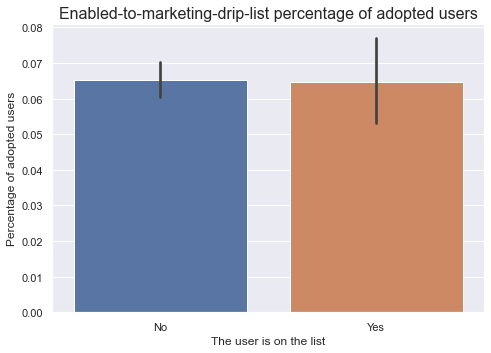

In [19]:
sns.barplot(x="enabled_for_marketing_drip", y="is_adopted", data=takehome_users)
plt.title('Enabled-to-marketing-drip-list percentage of adopted users', fontsize=16)
plt.xlabel('The user is on the list')
plt.xticks([0, 1], ["No", "Yes"], rotation=0)
plt.ylabel("Percentage of adopted users")

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0)
plt.show();

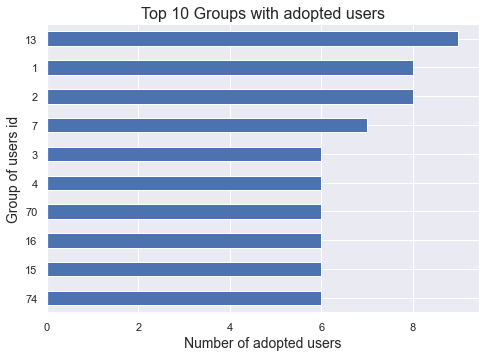

In [20]:
n = 10

# plot top group user id's
takehome_users[takehome_users['is_adopted'] == 1].org_id.value_counts(ascending=True)[-n:].plot(kind='barh')
plt.title("Top {} Groups with adopted users".format(n), fontsize=16)
plt.ylabel("Group of users id", fontsize=14)
plt.xlabel("Number of adopted users", fontsize=14)

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0)
plt.show();

These are the groups which concentrate more adopted users.

# Predict future user adoption

In [21]:
# transform the data to operate with - some variables are not relevant for the task
tk_df = takehome_users.copy().drop(['name', 'email', 'last_session_creation_time', 'object_id', 'invited_by_user_id'],
                                   axis=1)
tk_df['creation_time'] = scale(tk_df['creation_time'])

tk_df = pd.get_dummies(tk_df)
tk_df.head()

C:\Users\danie\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


,creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,is_adopted,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1.290656,1,0,11,0,1,0,0,0,0
1,0.561296,0,0,1,0,0,1,0,0,0
2,-0.547419,0,0,94,0,0,1,0,0,0
3,-0.259511,0,0,1,0,1,0,0,0,0
4,-0.831499,0,0,193,0,1,0,0,0,0


In [22]:
# binary target
y = tk_df['is_adopted']

# exclude not relevant features, get dummy variables and normalize
X = tk_df.drop('is_adopted', axis=1)

# Split into train (70%) and test (30%) sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# LGBMClassifier

In [23]:
%time
import lightgbm as lgb

# instantiate the model
clf_lgb = lgb.LGBMClassifier(random_state=42, n_estimators=10, class_weight='balanced')

# train the model
clf_lgb.fit(X_train, y_train)

Wall time: 0 ns


LGBMClassifier(class_weight='balanced', n_estimators=10, random_state=42)

In [24]:
model = clf_lgb
model_name = 'LGBMClassifier'

In [25]:

# predict
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# score
print("Score:", model.score(X_test, y_test))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification report:\n", classification_report(y_test, y_pred))

#####################################################

# Compute predicted probabilities: y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute and print AUC score
print("\nAUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

Score: 0.6143333333333333

Confusion matrix:
 [[1706 1099]
 [  58  137]]

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.61      0.75      2805
           1       0.11      0.70      0.19       195

    accuracy                           0.61      3000
   macro avg       0.54      0.66      0.47      3000
weighted avg       0.91      0.61      0.71      3000


AUC: 0.7549961149961151


# Random Forest Classifier

In [26]:
%time
from sklearn.ensemble import RandomForestClassifier

# instantiate the model
clf_rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=10)

# train the model
clf_rf.fit(X_train, y_train)

Wall time: 0 ns


RandomForestClassifier(class_weight='balanced', n_estimators=10,
                       random_state=42)

In [27]:
model = clf_rf
model_name = 'RandomForestClassifier'

In [28]:
# predict
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# score
print("Score:", model.score(X_test, y_test))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification report:\n", classification_report(y_test, y_pred))

#####################################################

# Compute predicted probabilities: y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute and print AUC score
print("\nAUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

Score: 0.927

Confusion matrix:
 [[2772   33]
 [ 186    9]]

Classification report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96      2805
           1       0.21      0.05      0.08       195

    accuracy                           0.93      3000
   macro avg       0.58      0.52      0.52      3000
weighted avg       0.89      0.93      0.90      3000


AUC: 0.6586946386946387


# Gradient Boost Classifier

In [29]:
%time
from sklearn.ensemble import GradientBoostingClassifier

# instantiate the model
clf_gb = GradientBoostingClassifier(random_state=42, n_estimators=10)

# train the model
clf_gb.fit(X_train, y_train)

Wall time: 0 ns


GradientBoostingClassifier(n_estimators=10, random_state=42)

In [30]:
model = clf_gb
model_name = 'GradientBoostingClassifier'

In [31]:
# predict
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# score
print("Score:", model.score(X_test, y_test))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification report:\n", classification_report(y_test, y_pred))

#####################################################

# Compute predicted probabilities: y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute and print AUC score
print("\nAUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

Score: 0.935

Confusion matrix:
 [[2805    0]
 [ 195    0]]

Classification report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      2805
           1       0.00      0.00      0.00       195

    accuracy                           0.94      3000
   macro avg       0.47      0.50      0.48      3000
weighted avg       0.87      0.94      0.90      3000


AUC: 0.767235248411719


C:\Users\danie\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Hyperparameter Tuning

In [32]:
%time
from sklearn.model_selection import RandomizedSearchCV

# we will use all the parameters
gb = GradientBoostingClassifier(n_estimators=300, random_state=42)

# Set the hyperparameter grid of rf
params_gb = {'loss':['deviance', 'exponential'],
             'criterion': ['friedman_mse', 'mse', 'mae'], 
             'min_samples_split':[2,5,10,15,100],
             'min_samples_leaf':[1, 2, 5,10],
             'max_features':['auto', 'log2','sqrt',None],             
             'max_depth':[5,8,15,25,30,None]
            }

# RandomizedSearchCV
rs_gb = RandomizedSearchCV(estimator=gb, param_distributions=params_gb, cv=2, n_iter=2 ,n_jobs=-1)

# Fit to the training set
rs_gb.fit(X_train, y_train)      

# Extract best hyperparameters
best_hyperparams = rs_gb.best_params_
print('Best hyperparameters:\n', best_hyperparams)

Wall time: 0 ns
Best hyperparameters:
 {'min_samples_split': 100, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 30, 'loss': 'exponential', 'criterion': 'friedman_mse'}


In [33]:
# predict
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# score
print("Score:", model.score(X_test, y_test))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification report:\n", classification_report(y_test, y_pred))

#####################################################

# Compute predicted probabilities: y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute and print AUC score
print("\nAUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

Score: 0.935

Confusion matrix:
 [[2805    0]
 [ 195    0]]

Classification report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      2805
           1       0.00      0.00      0.00       195

    accuracy                           0.94      3000
   macro avg       0.47      0.50      0.48      3000
weighted avg       0.87      0.94      0.90      3000


AUC: 0.767235248411719


C:\Users\danie\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
tuned_gb = GradientBoostingClassifier(n_estimators=300, random_state=42)
tuned_gb.fit(X_train, y_train)

model = tuned_gb
model_name = 'Tuned GradientBoostClassifier'

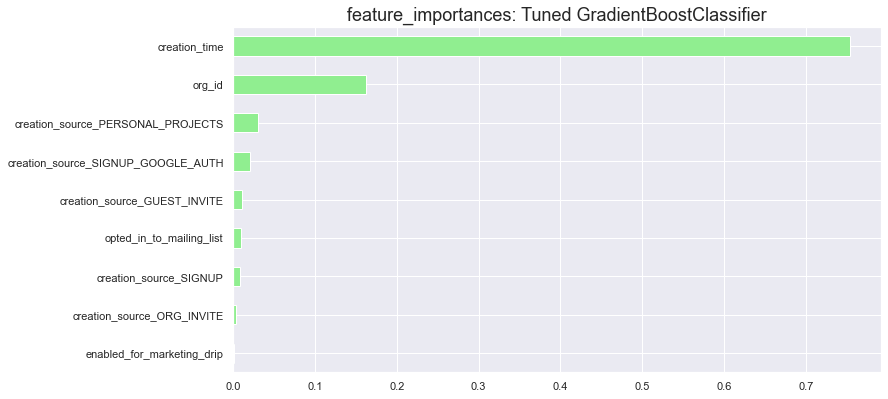

In [35]:
# X columns
X_columns = X.columns

# Create a pd.Series of features feature_importances
feature_importances = pd.Series(data=model.feature_importances_, index=X_columns)

# Sort feature_importances
feature_importances_sorted = feature_importances.sort_values()

# Draw a horizontal barplot of feature_importances_sorted
feature_importances_sorted.tail(100).plot(kind='barh', color='lightgreen')
plt.title('feature_importances: {}'.format(model_name), fontsize=18)
plt.subplots_adjust(left=0, bottom=-0.2, right=1.5, top=1, wspace=0, hspace=0)
plt.show();